In [16]:
#Line source, 90 deg bend, transmission measurements
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

#Define our Custom GaP Material using the Madarasz Sellmeier Model
GaP_range = mp.FreqRange(min=1/10, max=1/0.9)

GaP_frq1 = 1/(0.34264)
GaP_gam1 = 0
GaP_sig1 = 4.9113
GaP_frq2 = 1/(27.504)
GaP_gam2 = 0
GaP_sig2 = 1.9928

GaP_susc = [mp.LorentzianSusceptibility(frequency=GaP_frq1, gamma=GaP_gam1, sigma=GaP_sig1),
           mp.LorentzianSusceptibility(frequency=GaP_frq2, gamma=GaP_gam2, sigma=GaP_sig2)]

GaP = mp.Medium(epsilon=4.1705, E_susceptibilities=GaP_susc, valid_freq_range=GaP_range)


In [17]:
#Define simulation cell and resolution
resolution = 10 # pixels/um
sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx,sy,0)
dpml = 1.0
pml_layers = [mp.PML(dpml)]

#Define geometric variables
pad = 4  # padding distance between waveguide and cell edge
w = 1    # width of waveguide
wvg_xcen =  0.5*(sx-w-2*pad)  # x center of horiz. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of vert. wvg

#We run two simulations, one with only a straight waveguide (reference power), then a second simulation with a bend to calculate the transmission normalized by the reference power
#Straight WG only
geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                     material=GaP)]

#Use a gaussian line source to look at multiple frequencies
fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

#Define the simulation
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

#Define flux spectra calculation
nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))   #look at reflections 500nm from PML edge / source location.                        
refl = sim.add_flux(fcen, df, nfreq, refl_fr)                                                       #Note the flux region is twice as wide as the waveguide  

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0)) #Transmission measured at PML edge on other side
tran = sim.add_flux(fcen, df, nfreq, tran_fr) #Flux is computed for nfreq points between fcen +/- df/2

#When we later want to calculate reflectance, we have to be careful to separate incident light from actually reflected light
#We can do this by first saving the FT of the incident fields from this normalization reference simulation, then before we start 
#our second simulation of the bent structure we will load back these fields "negated", which subtracts the FT of the incident fields
#from the FT of the scattered fields

#Let's run the normalization simulation
pt = mp.Vector3(0.5*sx-dpml-0.5,wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3)) #This command runs the simulation for as long as it takes for the |Ez|^2 field to decay by a factor
                                                                           #of 1e3 from its peak value at the location defined by pt (in this case, the end of the waveguide)
                                                                           #Once this decay is reached, the simulation runs for an additional 50 time steps in case the amplitude rises again

# for normalization run, save incident flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl) #This saves the input fields as measured 500nm into the waveguide from the source location
# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.1705,4.1705,4.1705)
time for set_epsilon = 0.0789731 s
lorentzian susceptibility: frequency=0.0363583, gamma=0
lorentzian susceptibility: frequency=2.91852, gamma=0
-----------
field decay(t = 50.050000000000004): 1.221571185318245e-08 / 1.221571185318245e-08 = 1.0
field decay(t = 100.05000000000001): 0.03325987179723673 / 0.03325987179723673 = 1.0
field decay(t = 150.1): 0.013256305059976436 / 0.03325987179723673 = 0.39856753329631855
field decay(t = 200.15): 1.335841980011895e-14 / 0.03325987179723673 = 4.0163774176750687e-13
run 0 finished at t = 200.15 (4003 timesteps)


In [18]:
#Now we can run our second simulation with the bent structure

#First, reset the simulation we defined earlier
sim.reset_meep()

#Now define our new geometry with the bend
geometry = [mp.Block(mp.Vector3(sx-pad,w,mp.inf), center=mp.Vector3(-0.5*pad,wvg_ycen), material=GaP),
            mp.Block(mp.Vector3(w,sy-pad,mp.inf), center=mp.Vector3(wvg_xcen,0.5*pad), material=GaP)]

#Define our simulation region again
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

#Add back our transmission and reflection monitors
# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
# transmitted flux, defined at bottom of waveguide now
tran_fr = mp.FluxRegion(center=mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5,0), size=mp.Vector3(2*w,0,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normalization run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

#Run the simulation
pt = mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

#Retrieve the flux data and the frequency points from the monitors
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)
flux_freqs = mp.get_flux_freqs(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00010705 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.1705,4.1705,4.1705)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.1705,4.1705,4.1705)
time for set_epsilon = 0.087049 s
lorentzian susceptibility: frequency=0.0363583, gamma=0
lorentzian susceptibility: frequency=2.91852, gamma=0
-----------
field decay(t = 50.050000000000004): 4.095933147966656e-10 / 4.095933147966656e-10 = 1.0
field decay(t = 100.05000000000001): 1.1271358912281113e-06 / 1.1271358912281113e-06 = 1.0
field decay(t = 150.1): 0.00031944568730248615 / 0.00031944568730248615 = 1.0
field decay(t = 200.15): 0.006038373788323893 / 0.006038373788323893 = 1.0
fi

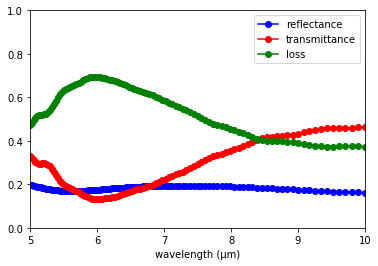

In [19]:
#Now lets plot the transmission, reflectance, and scattering loss
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])                          #vacuum wavelength = 1/freq
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])  #Reflectance = bent reflected flux / reference incident flux, multiply by -1 because -x direction
    Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])   #Transmission = bent transmitted flux / reference incident flux
    
if mp.am_master():
    plt.figure()
    plt.plot(wl,Rs,'bo-',label='reflectance')
    plt.plot(wl,Ts,'ro-',label='transmittance')
    plt.plot(wl,1-Rs-Ts,'go-',label='loss')
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()